In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 
from sklearn.preprocessing import StandardScaler
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score 

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"SciPy Version: {scipy.__version__}") 

torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.3.0+cu118
SciPy Version: 1.10.1


#### Introduction to Unsupervised Learning and Clustering

- Unsupervised Learning: Algorithms learn patterns from untagged/unlabeled data. 
- Clustering: A common  unsupervised task that aims to group similar data points together into clusters, such that points in the same cluster are more similar to each other than to those in other clusters. 

In [2]:
N_SAMPLES_CLUSTER = 300
N_CENTERS = 4       # number of clusters
CLUSTER_STD_DEV = 0.7   # cluster spreads

In [3]:
X_np_cluster, y_np_true_labels = make_blobs(
    n_samples=N_SAMPLES_CLUSTER,
    centers=N_CENTERS,
    cluster_std=CLUSTER_STD_DEV,
    random_state=42
)

In [4]:
scaler_cluster = StandardScaler()
X_scaled_np_cluster = scaler_cluster.fit_transform(X_np_cluster)

In [6]:
X_cluster_tensor = torch.from_numpy(X_scaled_np_cluster).float()
X_cluster_tensor.shape

torch.Size([300, 2])

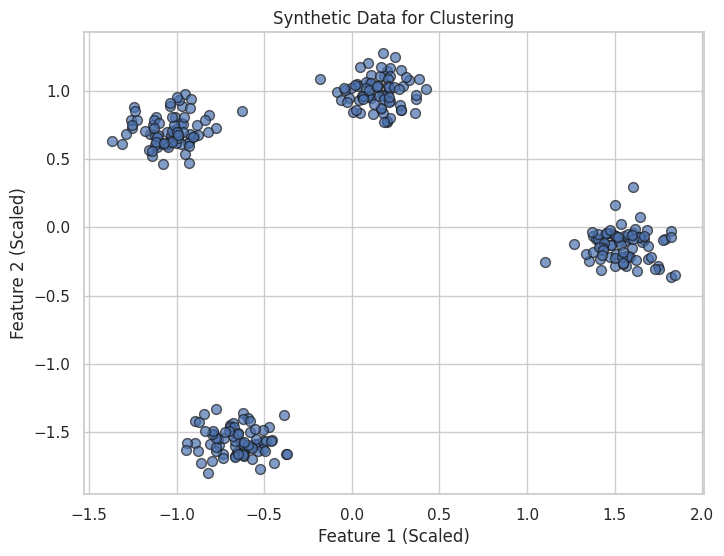

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(X_cluster_tensor[:, 0].numpy(), X_cluster_tensor[:, 1].numpy(),
            alpha=0.7, edgecolors='k', s=50)
plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.title("Synthetic Data for Clustering")
plt.show()

### K-Means Clustering
Algorithm:
1. Initialize K cluster centroids randomly (or using methods like K-means++)
2. Repeat until convergence (or max iterations):
    1. Assignment Step: Assign each data point to the nearest centroid.
    2. Update Step: Recalculate the centroids as the mean of all data points assigned to that centroid's cluster. 

In [9]:
class PyTorchKMeans:
    def __init__(self, n_clusters, max_iters=100, tol=1e-4, random_state=None):
        self.n_clusters_ = n_clusters
        self.max_iters_ = max_iters
        self.tol_ = tol
        self.centroids_ = None      # willl store final centroids
        self.labels_ = None     # store labels for each data point
        self.random_state_ = random_state
        if self.random_state_ is not None:
            torch.manual_seed(self.random_state_)

    def _initialize_centroids(self, X_data):
        """Randomly selects K data points as initial centroids."""
        n_samples = X_data.shape[0]
        indices = torch.randperm(n_samples)[:self.n_clusters_]
        initial_centroids = X_data[indices]
        return initial_centroids

    def _assign_to_clusters(self, X_data, centroids):
        """Assigns each data point to the closest centroid."""
        expanded_X = X_data.unsqueeze(1)
        expanded_centroids = centroids.unsqueeze(0)
        # squared Euclidean distances
        distances_sq = torch.sum((expanded_X - expanded_centroids)**2, dim=2)
        # assign to closest centroid (min distance)
        cluster_assignments = torch.argmin(distances_sq, dim=1)
        return cluster_assignments

    def _update_centroids(self, X_data, cluster_assignments):
        """Updates centroids to be the mean of assigned points."""
        n_features = X_data.shape[1]
        new_centroids = torch.zeros((self.n_clusters_, n_features), dtype=X_data.dtype, device=X_data.device)
        for k in range(self.n_clusters_):
            points_in_cluster_k = X_data[cluster_assignments == k]
            if len(points_in_cluster_k) > 0:
                new_centroids[k] = torch.mean(points_in_cluster_k, dim=0)
            else:
                new_centroids[k] = X_data[torch.randint(0, X_data.shape[0], (1,)).item()]
        return new_centroids

    def fit(self, X_data):
        current_centroids = self._initialize_centroids(X_data)
        for iteration in range(self.max_iters_):
            # assignment step
            cluster_assignments = self._assign_to_clusters(X_data, current_centroids)
            #update step
            new_centroids = self._update_centroids(X_data, cluster_assignments)
            # check for convergence
            centroid_shift = torch.sum((new_centroids - current_centroids)**2)
            current_centroids = new_centroids
            if iteration % 10 == 0 or iteration == self.max_iters_ -1 :
                print(f" Iteration {iteration+1}/{self.max_iters_}, Centroid shift: {centroid_shift.item():.4f}")
            if centroid_shift <= self.tol_:
                print(f"  Converged at iteration {iteration+1}.")
                break

        self.centroids_ = current_centroids
        self.labels_ = self._assign_to_clusters(X_data, self.centroids_)

    def predict(self, X_data):
        if self.centroids_ is None:
            raise RuntimeError("Model not fitted yet. Call fit() first.")
        return self._assign_to_clusters(X_data, self.centroids_)
                    

In [10]:
K_KMEANS = N_CENTERS
kmeans_torch = PyTorchKMeans(n_clusters=K_KMEANS, max_iters=100, random_state=42)
kmeans_torch.fit(X_cluster_tensor)

 Iteration 1/100, Centroid shift: 0.2727
  Converged at iteration 3.


In [12]:
final_centroids_kmeans = kmeans_torch.centroids_
final_labels_kmeans = kmeans_torch.labels_
final_labels_kmeans[:5]

tensor([0, 0, 3, 2, 0])

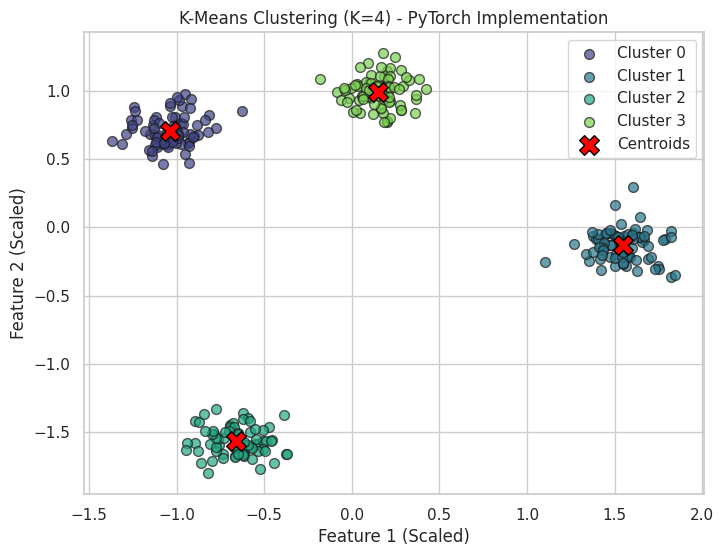

In [13]:
plt.figure(figsize=(8, 6))
# Plot data points colored by their assigned cluster
unique_assigned_labels = torch.unique(final_labels_kmeans)
colors_kmeans = sns.color_palette("viridis", n_colors=len(unique_assigned_labels))

for i, label_val in enumerate(unique_assigned_labels):
    cluster_mask = (final_labels_kmeans == label_val)
    plt.scatter(X_cluster_tensor[cluster_mask, 0].numpy(), X_cluster_tensor[cluster_mask, 1].numpy(),
                color=colors_kmeans[i], label=f'Cluster {label_val.item()}', alpha=0.7, edgecolors='k', s=50)

# Plot centroids
plt.scatter(final_centroids_kmeans[:, 0].numpy(), final_centroids_kmeans[:, 1].numpy(),
            marker='X', s=200, color='red', edgecolors='black', label='Centroids')

plt.xlabel("Feature 1 (Scaled)")
plt.ylabel("Feature 2 (Scaled)")
plt.title(f"K-Means Clustering (K={K_KMEANS}) - PyTorch Implementation")
plt.legend()
plt.show()

#### Choosing K (Elbow Method & Silhouette Score - Conceptual) 
The Elbow Method:
- Plot Sum of Squared Errors (SSE) or Within-Cluster Sum of Squares (WCSS)
  for different values of K.
- WCSS = Σ_clusters Σ_points_in_cluster ||point - centroid_of_cluster||^2
- Look for an "elbow" point in the plot where adding more clusters doesn't
  significantly reduce WCSS.

Silhouette Score:
- Measures how similar a data point is to its own cluster compared to other clusters.
- Ranges from -1 to 1. Higher values indicate better-defined clusters.
- Calculate average Silhouette Score for different K values.

In [15]:
# Example of calculating WCSS for our fitted model
wcss = 0
for k_idx in range(K_KMEANS):
    points_in_k = X_cluster_tensor[final_labels_kmeans == k_idx]
    if len(points_in_k) > 0:
        centroid_k = final_centroids_kmeans[k_idx]
        wcss += torch.sum((points_in_k - centroid_k)**2)
print(f"WCSS for K={K_KMEANS}: {wcss.item():.2f}")

WCSS for K=4: 8.70


In [17]:
# Silhouette score 
try:
    if X_cluster_tensor.shape[0] > 1 : # Silhouette needs at least 2 samples per cluster (often more for meaningful score)
        silhouette_avg = silhouette_score(X_cluster_tensor.numpy(), final_labels_kmeans.numpy())
        print(f"Silhouette Score for K={K_KMEANS}: {silhouette_avg:.4f}")
    else:
        print("Not enough samples or clusters for a meaningful silhouette score.")
except ValueError as e:
    print(f"Could not calculate silhouette score: {e}")

Silhouette Score for K=4: 0.8592


#### Hierarchical clustering
Algorithm (Agglomerative):
1. Start with each data point as its own cluster.
2. Repeat:
   1. Find the two closest clusters.
   2. Merge them into a new cluster.
   3. Update the distance matrix (distances between new cluster and others).
3. Stop when all points are in a single cluster (or a desired number of clusters is reached).

In [21]:
# linkage() function computes the hierarchical clustering
# 'ward' linkage often gives good results.
# Other methods: 'single', 'complete', 'average', 'weighted', 'centroid', 'median'
linkage_matrix_ward = linkage(X_cluster_tensor, method='ward', metric='euclidean')
linkage_matrix_complete = linkage(X_cluster_tensor, method='complete', metric='euclidean')

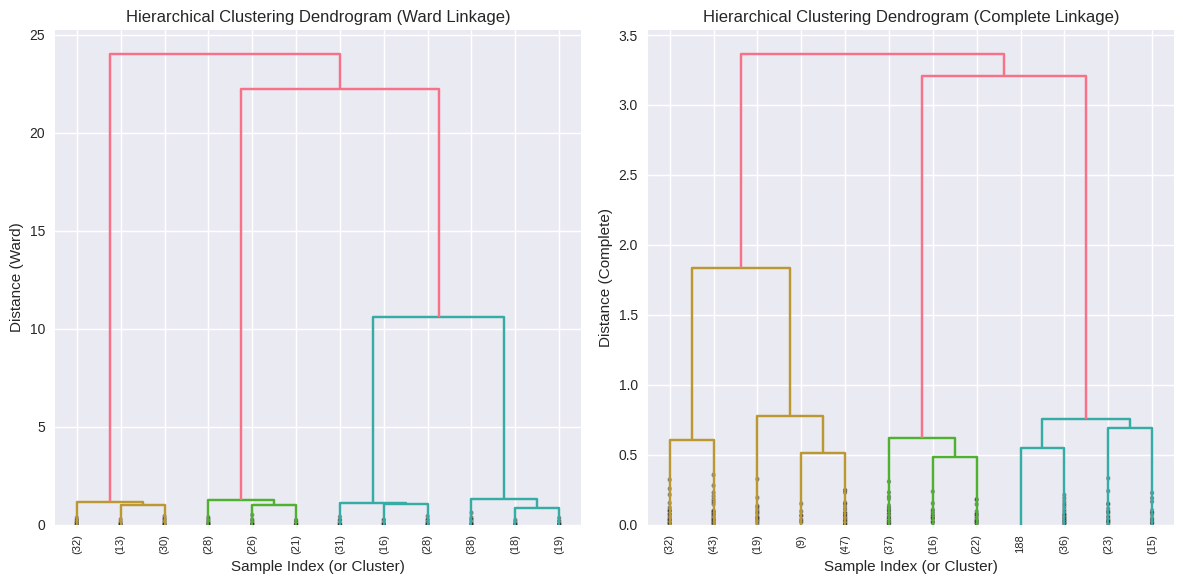

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index (or Cluster)')
plt.ylabel('Distance (Ward)')
dendrogram(linkage_matrix_ward, truncate_mode='lastp', p=12,
           leaf_rotation=90., leaf_font_size=8., show_contracted=True)

plt.subplot(1, 2, 2)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Sample Index (or Cluster)')
plt.ylabel('Distance (Complete)')
dendrogram(
    linkage_matrix_complete,
    truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=8., show_contracted=True
)
plt.tight_layout()
plt.show()

#### Obtaining flat clusters from dendrogram

In [27]:
# we can cut the dendrogram at a certain height (distance threshold) or specify the desired nuber of clusters
num_hier_clusters = N_CENTERS
hier_labels_by_k = fcluster(linkage_matrix_ward, t=num_hier_clusters, criterion='maxclust')
num_hier_clusters

4

In [28]:
hier_labels_by_k

array([4, 4, 3, 1, 4, 1, 2, 1, 3, 2, 3, 2, 3, 3, 4, 3, 4, 2, 3, 3, 2, 3,
       1, 4, 3, 4, 4, 1, 1, 2, 3, 2, 4, 2, 4, 3, 4, 1, 4, 1, 2, 3, 4, 1,
       3, 3, 4, 2, 4, 2, 1, 4, 1, 3, 1, 2, 4, 2, 2, 3, 4, 2, 2, 4, 1, 1,
       1, 1, 1, 3, 1, 1, 4, 2, 3, 4, 1, 1, 3, 1, 3, 3, 4, 3, 1, 4, 4, 2,
       2, 2, 4, 3, 4, 3, 3, 4, 1, 3, 4, 4, 2, 2, 2, 3, 3, 3, 3, 3, 1, 4,
       2, 3, 3, 3, 3, 2, 4, 1, 4, 1, 1, 1, 3, 4, 1, 4, 4, 3, 4, 1, 2, 3,
       3, 3, 3, 2, 2, 4, 3, 1, 3, 2, 1, 3, 2, 2, 2, 2, 1, 3, 3, 4, 2, 1,
       3, 2, 1, 4, 4, 2, 3, 4, 1, 4, 2, 4, 1, 3, 3, 3, 3, 3, 1, 2, 2, 1,
       1, 2, 2, 1, 4, 3, 4, 2, 2, 4, 1, 3, 2, 2, 1, 1, 1, 4, 2, 1, 1, 2,
       2, 4, 3, 3, 1, 2, 3, 1, 1, 4, 1, 3, 3, 1, 1, 2, 4, 1, 4, 4, 3, 4,
       4, 1, 4, 1, 2, 2, 4, 4, 2, 2, 2, 4, 3, 1, 2, 1, 4, 2, 4, 4, 4, 1,
       1, 2, 4, 1, 1, 1, 4, 1, 4, 1, 4, 2, 1, 4, 2, 3, 4, 3, 2, 3, 4, 3,
       1, 2, 1, 2, 2, 3, 3, 1, 2, 2, 4, 4, 1, 3, 3, 2, 2, 2, 2, 1, 4, 2,
       1, 2, 2, 1, 3, 1, 2, 3, 4, 3, 2, 3, 4, 4], d

In [30]:
# Visualize Hierarchical Clustering Results
hier_labels_plot = torch.from_numpy((hier_labels_by_k - 1).astype(np.int_))
hier_labels_plot

tensor([3, 3, 2, 0, 3, 0, 1, 0, 2, 1, 2, 1, 2, 2, 3, 2, 3, 1, 2, 2, 1, 2, 0, 3,
        2, 3, 3, 0, 0, 1, 2, 1, 3, 1, 3, 2, 3, 0, 3, 0, 1, 2, 3, 0, 2, 2, 3, 1,
        3, 1, 0, 3, 0, 2, 0, 1, 3, 1, 1, 2, 3, 1, 1, 3, 0, 0, 0, 0, 0, 2, 0, 0,
        3, 1, 2, 3, 0, 0, 2, 0, 2, 2, 3, 2, 0, 3, 3, 1, 1, 1, 3, 2, 3, 2, 2, 3,
        0, 2, 3, 3, 1, 1, 1, 2, 2, 2, 2, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 0, 3, 0,
        0, 0, 2, 3, 0, 3, 3, 2, 3, 0, 1, 2, 2, 2, 2, 1, 1, 3, 2, 0, 2, 1, 0, 2,
        1, 1, 1, 1, 0, 2, 2, 3, 1, 0, 2, 1, 0, 3, 3, 1, 2, 3, 0, 3, 1, 3, 0, 2,
        2, 2, 2, 2, 0, 1, 1, 0, 0, 1, 1, 0, 3, 2, 3, 1, 1, 3, 0, 2, 1, 1, 0, 0,
        0, 3, 1, 0, 0, 1, 1, 3, 2, 2, 0, 1, 2, 0, 0, 3, 0, 2, 2, 0, 0, 1, 3, 0,
        3, 3, 2, 3, 3, 0, 3, 0, 1, 1, 3, 3, 1, 1, 1, 3, 2, 0, 1, 0, 3, 1, 3, 3,
        3, 0, 0, 1, 3, 0, 0, 0, 3, 0, 3, 0, 3, 1, 0, 3, 1, 2, 3, 2, 1, 2, 3, 2,
        0, 1, 0, 1, 1, 2, 2, 0, 1, 1, 3, 3, 0, 2, 2, 1, 1, 1, 1, 0, 3, 1, 0, 1,
        1, 0, 2, 0, 1, 2, 3, 2, 1, 2, 3,

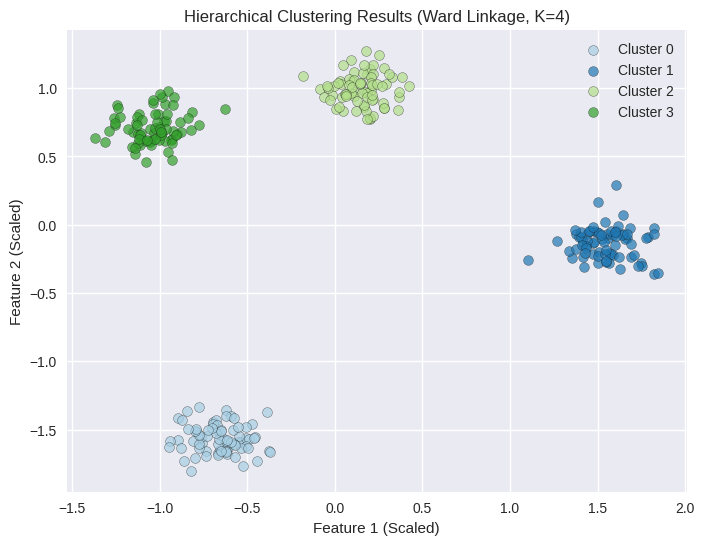

In [31]:
plt.figure(figsize=(8, 6))
unique_hier_labels = torch.unique(hier_labels_plot)
colors_hier = sns.color_palette("Paired", n_colors=len(unique_hier_labels))

for i, label_val in enumerate(unique_hier_labels):
    cluster_mask = (hier_labels_plot == label_val)
    plt.scatter(X_cluster_tensor[cluster_mask, 0].numpy(), X_cluster_tensor[cluster_mask, 1].numpy(),
                color=colors_hier[i], label=f'Cluster {label_val.item()}', alpha=0.7, edgecolors='k', s=50)

plt.xlabel("Feature 1 (Scaled)"); plt.ylabel("Feature 2 (Scaled)")
plt.title(f"Hierarchical Clustering Results (Ward Linkage, K={num_hier_clusters})")
plt.legend()
plt.show()